# Solve RCPSP by constraint programming

One of the main class of methods to solve discrete optimization problem is Constraint programming [(CP)](https://en.wikipedia.org/wiki/Constraint_programming). CP solvers explore the state variables and propagate constraints in a clever way. Using constraint programming, users declaratively state the constraints on the feasible solutions for a set of decision variables. Constraints specify the properties of a solution to be found.
In discrete-optimization library, [minizinc](https://www.minizinc.org/) declarative language and its [python api](https://minizinc-python.readthedocs.io/en/latest/) is used extensively. However it is quite easy to use other modeling library such as [Cpmpy](https://github.com/CPMpy/cpmpy/tree/master/cpmpy) in the future.
Some constraint programming models are stored in discrete_optimization/knapsack/minizinc folder.

In this notebook, we'll use the [chuffed](https://github.com/chuffed/chuffed#description) solver which is a state of the art lazy clause solver. 

We assume that you have already been introduced to RCPSP problems thanks to this [notebook](RCPSP%20%231%20Introduction.ipynb).

In [1]:
import logging

import nest_asyncio

# patch asyncio so that applications using async functions can run in jupyter
nest_asyncio.apply()

# set logging level
logging.basicConfig(level=logging.INFO)

In [2]:
import os
workingDirInit = os.getcwd()
workingDir = workingDirInit
parentDir = ((os.path.dirname(os.path.dirname(os.path.abspath(''))))) # ../../../
print('working dir ' + workingDir)
print('path dir ' + parentDir)

working dir C:\Users\l.corzo\source\repos\MS_RCPSP\Notebooks\RCPSPtutorials
path dir C:\Users\l.corzo\source\repos\MS_RCPSP


In [3]:
import sys
sys.path
sys.path.append(parentDir)
print(sys.path)

['C:\\Users\\l.corzo\\source\\repos\\MS_RCPSP\\Notebooks\\RCPSPtutorials', 'C:\\Users\\l.corzo\\Anaconda3\\envs\\rcpsp_code_env\\python38.zip', 'C:\\Users\\l.corzo\\Anaconda3\\envs\\rcpsp_code_env\\DLLs', 'C:\\Users\\l.corzo\\Anaconda3\\envs\\rcpsp_code_env\\lib', 'C:\\Users\\l.corzo\\Anaconda3\\envs\\rcpsp_code_env', '', 'C:\\Users\\l.corzo\\Anaconda3\\envs\\rcpsp_code_env\\lib\\site-packages', 'C:\\Users\\l.corzo\\Anaconda3\\envs\\rcpsp_code_env\\lib\\site-packages\\win32', 'C:\\Users\\l.corzo\\Anaconda3\\envs\\rcpsp_code_env\\lib\\site-packages\\win32\\lib', 'C:\\Users\\l.corzo\\Anaconda3\\envs\\rcpsp_code_env\\lib\\site-packages\\Pythonwin', 'C:\\Users\\l.corzo\\source\\repos\\MS_RCPSP']


In [4]:
from Code.parser_calendar import load_domain
from Code.rcpsp_datasets import get_complete_path
from Code.rcpsp_calendar import parse_file
from Code.rcpsp_calendar_utils import (plot_resource_individual_gantt,
                                       plot_ressource_view, plot_task_gantt,
                                       save_task_gantt_resolution,
                                       plt)

## Constraint modelling
The simplest constraint model for RCPSP can be found in the library at this [path](../discrete_optimization/rcpsp/minizinc/rcpsp_single_mode_mzn.mzn) (rcpsp/minizinc/rcpsp_single_mode_mzn.mzn). 

Contrary to the linear programming formulation, no need of binary variable (that were needed to make the formulation linear). The decisions variable are directly the starting time of the task. 
The precedence constraints are then quite trivial to write

$\forall t_1, \forall t_2 \in \text{successors}(t_1), start[t_2]\geq start[t_1]$

About the cumulative constraint, we use the <b>global</b> constraint *cumulative* that is native in minizing language : see [here](https://www.minizinc.org/doc-2.5.5/en/lib-globals.html#index-119) for more details.

## Parsing model

In [5]:
file_name = "j601_1_calendar.sm"
rcpsp_problem = parse_file(get_complete_path(file_name))

## CP Solver 

In [6]:
from discrete_optimization.rcpsp.solver.cp_solvers import (
    CP_RCPSP_MZN,
    CPSolverName,
    ParametersCP,
)

INFO:mip.model:Using Python-MIP package version 1.15.0


In [8]:
solver = CP_RCPSP_MZN(rcpsp_model=rcpsp_problem, cp_solver_name=CPSolverName.CHUFFED)
solver.init_model()
parameters_cp = ParametersCP.default()
parameters_cp.time_limit = 200
results = solver.solve(parameters_cp=parameters_cp)

For this instance, the solving is very fast (should be faster than when testing the previous Linear Programming isn't it ?). CP is here able to return optimal solution almost instantly.

<IPython.core.display.Javascript object>


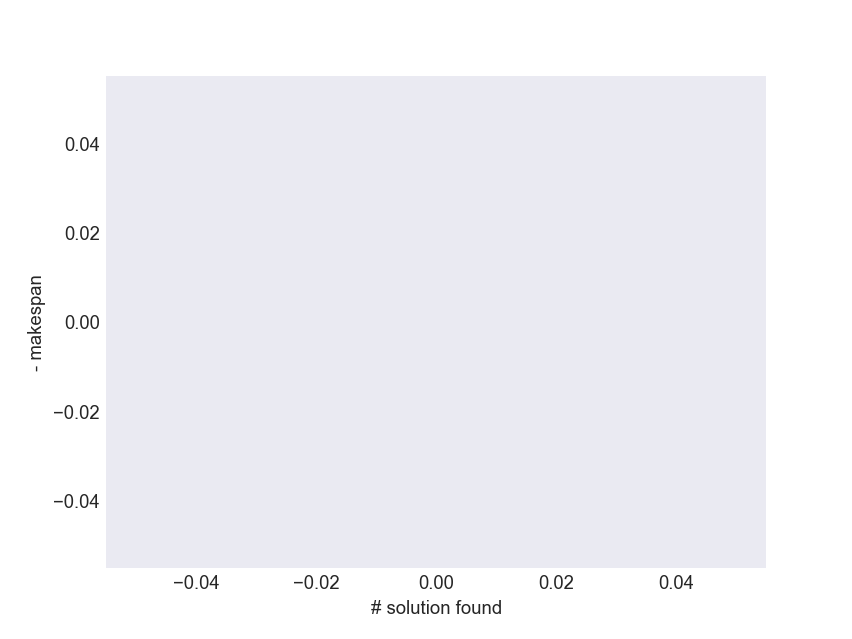

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1)
ax.plot([x[1] for x in results.list_solution_fits], marker="o")
ax.set_ylabel("- makespan")
ax.set_xlabel("# solution found")
plt.show()

In [15]:
# Retrieve the best_solution, fit found by the solver.
best_solution, fit = results.get_best_solution_fit()
# Print fitness
print(fit)
# Check if the solution satisfies the constraints
print("Satisfaction :", rcpsp_problem.satisfy(best_solution))
# Evaluation :
print("Evaluation :", rcpsp_problem.evaluate(best_solution))

None


AttributeError: 'NoneType' object has no attribute 'rcpsp_schedule_feasible'

### Plot the solution

In [ ]:
from discrete_optimization.rcpsp.rcpsp_utils import plot_ressource_view

plot_ressource_view(rcpsp_model=rcpsp_problem, rcpsp_sol=best_solution)
# plot_task_gantt(rcpsp_model=rcpsp_problem, rcpsp_sol=best_solution)

Constraint programming is the state of the art method to solve scheduling problems like $RCPSP$. It is therefore not surprising to get fast and good solutions for this limited-size instance. 
Many other models have been developed in the library to tackle complex variants of scheduling problems.
Few characteristics of such scheduling problems are the following : 
- variable resource availability
- multimode task execution (for example a task can be fast+highly resource demanding or slow+low resource demanding)
- preemptive scheduling : ability to pause and resume task.
